## Sentiment analyse twitter

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re

### We load an explore our labeled dataset 

labeld training set can be download from:http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

In [3]:
##This chunck is for reading in the train and test data, including a little bit of exploratory.

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("C:\\Users\\Jeffr\\Downloads\\training.1600000.processed.noemoticon.csv",header=None, names=cols,encoding="ISO-8859–1")
# above line will be different depending on where you saved your data, and your file name
df.head()
df.drop(['id','date','query_string','user'],axis=1,inplace=True) ## Drop the rows that we dont need
df[df.sentiment == 4].head(10) ## Show some rows of sentiment 4 , looks like 4 is positive


,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [4]:
df[df.sentiment == 0].head(10) ## Show some rows of sentiment 0, looks like 0 is negative

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [5]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1}) ## Map indicater 4 to 1
df.sentiment.value_counts() ## Check how much labeled is 800k sentiment 4 and 800k sentiment 0

1    800000
0    800000
Name: sentiment, dtype: int64

## We load our untagged dataset

In [29]:
%%time
# Verander in de regel hieronder de locatie van de data
tweets = pd.read_json("C:\\Users\\Jeffr\\Downloads\\mini_twitter_geotagged_clean.json", orient='records', lines=True)


Wall time: 10.5 s


In [31]:
tweets['ID'] = tweets.index ## Performance reasons and slicing for myself
tweets = tweets[['ID','id','CleanText','text','entities','in_reply_to_status_id', 'quoted_status_id','place']]
tweets.head()

,ID,id,CleanText,text,entities,in_reply_to_status_id,quoted_status_id,place
0,0,764039733076897792,\n\n\nALL IN COLLUSION TOGETHER \n\n\n\n\n\n\nhttpstco5GMNZq40V3,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE \n\n@realDonaldTrump \n#TrumpPence \n\nhttps://t.co/5GMNZq40V3,"{'hashtags': [{'text': 'NOJUSTICE', 'indices': [62, 72]}, {'text': 'TrumpPence', 'indices': [93, 104]}], 'urls': [{'url': 'https://t.co/5GMNZq40V3', 'expanded_url': 'http://www.zerohedge.com/news/2016-08-11/justice-department-prevented-fbi-probe-clinton-foundation-reporters-slam-state-depar', 'display_url': 'zerohedge.com/news/2016-08-1…', 'indices': [107, 130]}], 'user_mentions': [{'screen_name': 'BarackObama', 'name': 'Barack Obama', 'id': 813286, 'id_str': '813286', 'indices': [0, 12]}, {'screen_name': 'FBI', 'name': 'FBI', 'id': 17629860, 'id_str': '17629860', 'indices': [14, 18]}, {'screen_name': 'LorettaLynch', 'name': 'AG Loretta Lynch', 'id': 3290070855, 'id_str': '3290070855', 'indices': [19, 32]}, {'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [75, 91]}], 'symbols': []}",NaN,NaN,"{'id': 'c7ef5f3368b68777', 'url': 'https://api.twitter.com/1.1/geo/id/c7ef5f3368b68777.json', 'place_type': 'city', 'name': 'Baton Rouge', 'full_name': 'Baton Rouge, LA', 'country_code': 'US', 'country': 'United States', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-91.218994, 30.354161], [-91.218994, 30.564039], [-90.962605, 30.564039], [-90.962605, 30.354161]]]}, 'attributes': {}}"
1,1,764039812479225856,he will do in one year all the things you should have done in eight,@HillaryClinton he will do in one year all the things you should have done in eight,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'HillaryClinton', 'name': 'Hillary Clinton', 'id': 1339835893, 'id_str': '1339835893', 'indices': [0, 15]}], 'symbols': []}",7.626233e+17,NaN,"{'id': '01864a8a64df9dc4', 'url': 'https://api.twitter.com/1.1/geo/id/01864a8a64df9dc4.json', 'place_type': 'city', 'name': 'Melbourne', 'full_name': 'Melbourne, Victoria', 'country_code': 'AU', 'country': 'Australia', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[144.593742, -38.433859], [144.593742, -37.511274], [145.512529, -37.511274], [145.512529, -38.433859]]]}, 'attributes': {}}"
2,2,764039849850482689,clear deliberately throwing this racein 2007 he knew that and destabilization of Mideast started wIraq invasion,"#CNN #newday clear #Trump deliberately throwing this race,in 2007 he knew that #ISIS and destabilization of Mideast started w/Iraq invasion","{'hashtags': [{'text': 'CNN', 'indices': [0, 4]}, {'text': 'newday', 'indices': [5, 12]}, {'text': 'Trump', 'indices': [19, 25]}, {'text': 'ISIS', 'indices': [79, 84]}], 'urls': [], 'user_mentions': [], 'symbols': []}",NaN,NaN,"{'id': 'c0b8e8dc81930292', 'url': 'https://api.twitter.com/1.1/geo/id/c0b8e8dc81930292.json', 'place_type': 'city', 'name': 'Baltimore', 'full_name': 'Baltimore, MD', 'country_code': 'US', 'country': 'United States', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-76.711521, 39.197211], [-76.711521, 39.372215], [-76.529443, 39.372215], [-76.529443, 39.197211]]]}, 'attributes': {}}"
3,3,764039917924069376,you wouldnt recognize a lie if it came from your own mouth and they do continually NeverTrump,"@realDonaldTrump, you wouldn't recognize a lie if it came from your own mouth, and they do continually. #NeverTrump https://t.co/pKSQM8yikm","{'hashtags': [{'text': 'NeverTrump', 'indices': [104, 115]}], 'urls': [{'url': 'https://t.co/pKSQM8yikm', 'expanded_url': 'https://twitter.com/realdonaldtrump/status/763950742755434498', 'display_url': 'twitter.com/realdonaldtrum…', 'indices': [116, 139]}], 'user_mentions': [{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [0, 16]}], 'symbols': []}",NaN,7.639507e+17,"{'id': '4265ece9285a2872', 'url': 'https://api.twitter.com/1.1/

In [32]:
# Create a new coloumn that contains a list with all the mentions used in the tweet
def mentionfinder(row):
    mentions = re.findall('(?<![@\w])@(\w{1,25})', row['text'])
    mentions = [x.lower() for x in mentions]
    #mentions = tuple(mentions)
    return mentions

tweets['Mentions'] = tweets.apply(lambda row: mentionfinder(row), axis=1)

In [33]:
# Create a new coloumn that contains a list with all the hastags used in the tweet
def hashtagfinder(row):
    hashtags = re.findall('(?:(?<=\s)|(?<=^))#.*?(?=\s|$|\'|\-|[.,\/#!$%\^&\*;:{}=\-_`~()])', row['text']) 
    hashtags = [x.lower() for x in hashtags]
    return hashtags

tweets['Hashtags'] = tweets.apply(lambda row: hashtagfinder(row), axis=1)

In [11]:
tweets.head()

,ID,id,CleanText,text,entities,in_reply_to_status_id,quoted_status_id,Mentions,Hashtags
0,0,764039733076897792,\n\n\nALL IN COLLUSION TOGETHER \n\n\n\n\n\n\n...,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"{'hashtags': [{'text': 'NOJUSTICE', 'indices':...",NaN,NaN,"[barackobama, fbi, lorettalynch, realdonaldtrump]","[#nojustice, #trumppence]"
1,1,764039812479225856,he will do in one year all the things you shou...,@HillaryClinton he will do in one year all the...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",7.626233e+17,NaN,[hillaryclinton],[]
2,2,764039849850482689,clear deliberately throwing this racein 2007 h...,#CNN #newday clear #Trump deliberately throwin...,"{'hashtags': [{'text': 'CNN', 'indices': [0, 4...",NaN,NaN,[],"[#cnn, #newday, #trump, #isis]"
3,3,764039917924069376,you wouldnt recognize a lie if it came from y...,"@realDonaldTrump, you wouldn't recognize a lie...","{'hashtags': [{'text': 'NeverTrump', 'indices'...",NaN,7.639507e+17,[realdonaldtrump],[#nevertrump]
4,4,764039926161604608,Kid you know suing someone Thats the most beau...,"""Kid, you know, suing someone? Thats the most ...","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,"[funnyordie, realdonaldtrump]",[]


In [12]:
len(tweets)

46811

## Cleansing the tagged train data
The untagged dataset is already cleansed in the Preprocessing.ipynb
* Removal of http and www links
* Removal of hashtags #
* Removal of multiple spaces

In addition we delete enter and tab encoding. And words that are smaller than 3 letters.

In [13]:
def clean_string(row):
    # remove http and www links from string
    rem_hl = re.sub(r'(http\S+) | (www\S+) | (https\S+)', '', row['text'])
    
    # remove @.. from string
    rem_at_hl = re.sub(r'@(\w+) |@(\w+)', '', rem_hl)
    
    # remove hashtags #.. from string
    rem_hash_at_hl = re.sub(r'#(\w+) |@(\w+)', '', rem_at_hl)

    rem_inter = re.sub(r'[^\w\s]','', rem_hash_at_hl)
    
    # remove multiple spaces
    rem_space = re.sub(' +',' ',rem_inter)
    #print (re.search('[a-zA-Z]', rem_space))
    if (re.search('[a-zA-Z]', rem_space) == None):
        return("emptyStringRetured")
    else:
        return (rem_space)


In [14]:
df['text'] = df.apply(lambda row: clean_string(row), axis=1)

In [15]:
tweets['CleanText'] = tweets['CleanText'].replace('\n','')
tweets['CleanText'] = tweets['CleanText'].replace('\t','')

df['text'] = df['text'].replace('\n','')
df['text'] = df['text'].replace('\t','')

tweets['CleanText'] = tweets['CleanText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


tweets['CleanText'] =tweets['CleanText'].str.lower()
df['text'] = df['text'].str.lower()

In [16]:
np.sum(df.isnull().any(axis=1))
df.isnull().any(axis=0)

sentiment    False
text         False
dtype: bool

In [15]:
## This chuck is ment for further exploration
# df.isnull().any(axis=0)
# np.sum(df.isnull().any(axis=1))
# tweets.isnull().any(axis=0)
# np.sum(tweets.isnull().any(axis=1))
df.head() 
tweets.head()

,ID,id,CleanText,text,entities,in_reply_to_status_id,quoted_status_id,Mentions,Hashtags
0,0,764039733076897792,collusion together httpstco5gmnzq40v3,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"{'hashtags': [{'text': 'NOJUSTICE', 'indices':...",NaN,NaN,"[barackobama, fbi, lorettalynch, realdonaldtrump]","[#nojustice, #trumppence]"
1,1,764039812479225856,will year things should have done eight,@HillaryClinton he will do in one year all the...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",7.626233e+17,NaN,[hillaryclinton],[]
2,2,764039849850482689,clear deliberately throwing this racein 2007 k...,#CNN #newday clear #Trump deliberately throwin...,"{'hashtags': [{'text': 'CNN', 'indices': [0, 4...",NaN,NaN,[],"[#cnn, #newday, #trump, #isis]"
3,3,764039917924069376,wouldnt recognize came from your mouth they co...,"@realDonaldTrump, you wouldn't recognize a lie...","{'hashtags': [{'text': 'NeverTrump', 'indices'...",NaN,7.639507e+17,[realdonaldtrump],[#nevertrump]
4,4,764039926161604608,know suing someone thats most beautiful thing ...,"""Kid, you know, suing someone? Thats the most ...","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,"[funnyordie, realdonaldtrump]",[]


## Word counts in labeld data

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df.text)

neg_doc_matrix = cvec.transform(df[df.sentiment == 0].text)
pos_doc_matrix = cvec.transform(df[df.sentiment == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [18]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
have,82462,62039,144501
that,72583,68739,141322
just,63178,61874,125052
with,49919,64926,114845
this,52087,40890,92977
good,28551,60840,89391
like,40639,37106,77745
dont,44916,22009,66925
your,20752,44244,64996
today,36189,28400,64589


## Sentiment analyse --Step 1 splitting the data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values, test_size=0.2)

## Sentiment analyse -- Step 2 tokanize

In [20]:
import sklearn
vect = CountVectorizer() ## This is the tokanizer
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)


In [21]:
tf_train ##1280k

<1280000x396429 sparse matrix of type '<class 'numpy.int64'>'
	with 8558648 stored elements in Compressed Sparse Row format>

In [22]:
tf_test ##320k

<320000x396429 sparse matrix of type '<class 'numpy.int64'>'
	with 2067249 stored elements in Compressed Sparse Row format>

In [23]:
## This chunk is ment to check if the porportions are still right
sum(y_train) ## 640107   is the half of 1280 k in the train set
sum(y_test) ## 159893   is the half of 320k in the test set

159926

## Sentiment analyse -- Step 3 Building a classifier

In [24]:
# p = sum of all feature count vectors with label 1
p = tf_train[y_train==1].sum(0) + 1
# q = sum of all feature count vectors with label 0
q = tf_train[y_train==0].sum(0) + 1
# Notice that we add 1 to both count vectors to ensure that every token appear at least one time in each class.

# The log-count ratio r is:
r = np.log((p/p.sum()) / (q/q.sum()))
# And b:
b = np.log(len(p) / len(q))

# Predictions

# With calculated coefficients we can now generate predictions on test set. Since we are trying to fit a linear classifier, the form of the linear equation is:

# y = mx + b
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()
accuracy


0.757859375

The accuracy is 75.8 % meaning that the algorithm classisfy the correct label in 3 out of the 44 labels.

In [25]:
## Visualize the data
test_outcome = pd.DataFrame({'text':X_test, 'Positive':np.asarray(preds)[0]})
test_outcome.head(15)

,text,Positive
0,waking late getting yelled later worse,False
1,they really always though stupid dancing,False
2,last time went knocked some professional cycli...,False
3,glamorous definitely digging hair,True
4,being married vampire better sookie stalkhouse,True
5,please tell moving with that thing,True
6,friend america have sooo anoying,False
7,somehow cant reply your message know thank youuu,True
8,booo laptop brokennn going back best tomorrow ...,False
9,lady rest peace lovely missed httpappsfacebook...,True


## Sentiment analyse -- Step 4 Score out on our dataset

In [26]:
# Vectorize the unseen data
unseen = vect.transform(tweets.CleanText)
pre_unseen = unseen @ r.T + b
predictions_unseen = pre_unseen.T > 0

In [27]:
##Visualize the data
pd.options.display.max_rows  ## This is for showing all the text in the column (otherwise it will be half....)
pd.set_option('display.max_colwidth', -1)

Predictions_unseen_df = pd.DataFrame({'text':tweets.text, 'Positive':np.asarray(predictions_unseen)[0]})
Predictions_unseen_df.head(20)


,text,Positive
0,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE \n\n@realDonaldTrump \n#TrumpPence \n\nhttps://t.co/5GMNZq40V3,True
1,@HillaryClinton he will do in one year all the things you should have done in eight,True
2,"#CNN #newday clear #Trump deliberately throwing this race,in 2007 he knew that #ISIS and destabilization of Mideast started w/Iraq invasion",False
3,"@realDonaldTrump, you wouldn't recognize a lie if it came from your own mouth, and they do continually. #NeverTrump https://t.co/pKSQM8yikm",False
4,"""Kid, you know, suing someone? Thats the most beautiful thing 1 human being could do to another human being"" @funnyordie @realDonaldTrump😂💩s",True
5,"@HillaryClinton you ARE the co-founder of ISIS, you crooked, evil, lying, witch. How can you live with yourself?",False
6,@Geraldanthro @NeilTurner_ @realDonaldTrump want to do a comparison try maimed Vets pre &amp; post Iraq pullout. Bar graph that. @washingtonpost,False
7,@mike4193496 @realDonaldTrump I TOTALLY CONCUR!! This Election is just CRA CRA n Corruption in our Gov is Mind Blowing!! Trump= Last Hope!!!,True
8,"@realDonaldTrump @elsolarverde What issues? Your idiot claim that she ""founded"" ISIS? Trump will go to Hell for lying &amp; stealing. Shame!",False
9,Can't stand @HillaryClinton or @realDonaldTrump?Take a look. They can win...don't settle. #15for15 #TeamGov #YouIn https://t.co/YK336aaH98,False


In [28]:
## This is a check if we have still all the data (46811) in the dataframe
len(Predictions_unseen_df) #46811
sum(Predictions_unseen_df.Positive) ## Amount of positive == 24217

24533

## Write back the dataset to share / Add positive to dataframe

In [34]:
# tweets = pd.read_json("C:\\Users\\Jeffr\\Downloads\\twitter_geotagged_clean.json", orient='records', lines=True)
tweets["Positive"] = np.asarray(predictions_unseen)[0]
# tweets.head()
# tweets2 = tweets
# tweets.to_json('C:\\Users\\Jeffr\\Downloads\\twitter_geotagged_clean_including_sentiment.json', orient='records', lines=True)

# Vanaf hier begint de selectie op trump of hillary

In [29]:
# full = pd.merge(Predictions_unseen_df,tweets2, how='left', left_on='text', right_on='text')

In [36]:
Hillary = ['#dumptrump','#nevertrump', '#imwithher']
Neutral = ['#trumppence16', '#hillaryclinton', '#hillary', '#donaldtrump', '#trump']
NeutralTrump = ['#trumppence16', '#donaldtrump', '#trump', '#donaldtrump\'s', '#trump\'s']
NeutralHillary = ['#hillaryclinton', '#hillary', '#hillaryclinton\'s']
Trump = ['#maga', '#crookedhillary', '#neverhillary']
allhash = ['@HillaryClinton', '#maga', '#trumppence16', '#hillaryclinton', '#hillary', '#crookedhillary', '#donaldtrump', '#dumptrump', '@realDonaldTrump', '#nevertrump', '#imwithher', '#neverhillary', '#trump']

In [37]:
import math
"""
Assumption: Everyone that tweets negative about Hillary is for Trump 
(and the other way around).
"""
def trumphillary(row):
    #print(row)
    # HASHTAGS
    # First checking if there are hashtags used that are person specific
    if len(row['Hashtags']) != 0:
        if ('#dumptrump' in row['Hashtags'] or '#nevertrump' in row['Hashtags'] or '#imwithher' in row['Hashtags']) and ('#maga' in row['Hashtags'] or '#crookedhillary' in row['Hashtags'] or '#neverhillary' in row['Hashtags']):
            return 'Both'
        for i in range(len(row['Hashtags'])):
            if row['Hashtags'][i] in Hillary:
                return 'Hillary'
            elif row['Hashtags'][i] in Trump:
                return 'Trump'
            else:
                continue

    # MENTIONS        
    # Hillary is returned when Hillary is mentioned and something positive 
    # is said or if Trump is mentioned and something negative is said and 
    # Trump the other way around
    if len(row['Mentions']) != 0: 
        if 'HillaryClinton' in row['Mentions'] and 'realDonaldTrump' in row['Mentions']:
                return 'Both'
        for j in range(len(row['Mentions'])):
            if row['Mentions'][j] == "hillaryclinton":
                if row['Positive'] == True:
                    return 'Hillary'
                elif row['Positive'] == False:
                    return 'Trump'
                else:
                    continue
            elif row['Mentions'][j] == "realdonaldtrump":
                if row['Positive'] == True:
                    return 'Trump'
                elif row['Positive'] == False:
                    return 'Hillary'
                else:
                    continue
            else:
                continue
            
    
    # COMBINED
    if len(row['Hashtags']) != 0:
        #print(row)
        for i in range(len(row['Hashtags'])):
            if row['Hashtags'][i] in NeutralHillary:
                if row['Positive'] == True:
                    return 'Hillary'
                elif row['Positive'] == False:
                    return 'Trump'
                else:
                    continue
            if row['Hashtags'][i] in NeutralTrump:
                if row['Positive'] == True:
                    return 'Trump'
                elif row['Positive'] == False:
                    return 'Hillary'
                else:
                    continue
    
    # IF MENTIONS AND HASHTAGS AREN'T CLEAR ENOUGH
    
    if math.isnan(row['quoted_status_id']) == False:
        return 'Quoted'
    elif math.isnan(row['in_reply_to_status_id']) == False:
        return 'Reply'
    else:
        print(row)
        return 'Else'
tweets['For'] = tweets.apply(lambda row: trumphillary(row), axis=1)

ID                       296                                                                                                                                                                                                                                                                                                                                                                                             
id                       764051205215571968                                                                                                                                                                                                                                                                                                                                                                              
CleanText                Hey ImWithHer and were making Herstory together because were StrongerTogether                                                                              

ID                       2717                                                                                                                                                                                                                                                                                                                                                                                              
id                       764086301976956931                                                                                                                                                                                                                                                                                                                                                                                
CleanText                Calling ALL Christians we MUST stand against the tyranny of BAD LEADERSHIP Its Saul Clinton vs David Trump in every election                           

ID                       8602                                                                                                                                                                                                                                                                                                                                                                                                        
id                       764157868111265792                                                                                                                                                                                                                                                                                                                                                                                          
CleanText                Havent heard from Melania lately it she looking for another speech to plagiarize to defend Donald Try Mein KampfTrump              

ID                       11267                                                                                                                                                                                                                                                                                                                                                                                         
id                       764191748583264256                                                                                                                                                                                                                                                                                                                                                                            
CleanText                I researched US Conservatism and did not find one definition that included TTP openborder policies or supporting a lawless adminTrump                          

ID                       14168                                                                                                                                                                                                                                                                                                                                                                                                 
id                       764229886923841536                                                                                                                                                                                                                                                                                                                                                                                    
CleanText                How about stopping the false equivalency BS HC has been under microscope for 30 yrs amp DT is a lying assholeTrump                             

ID                       18080                                                                                                                                                                                                                                                                                                                                                                                                       
id                       764275679718322176                                                                                                                                                                                                                                                                                                                                                                                          
CleanText                Its like he just he shat Trump dumps s input on how much I hate that Trumps kids look like him DonaldTrump                         

ID                       21960                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
id                       764365146458247168                                                                                                                                                                                                                                                                                                                                                                     

ID                       25076                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
id                       764469629930594305                                                                                                                                                                                                 

ID                       28469                                                                                                                                                                                                                                                                                                                                                                                                       
id                       764528089657466880                                                                                                                                                                                                                                                                                                                                                                                          
CleanText                Trump cant prove the size of his manhood to all of us but he sure showed us the size of his brain the past two weeks UndersizedTrum

ID                       31369                                                                                                                                                                                                                                                                                                                                                                                                           
id                       764566572140785664                                                                                                                                                                                                                                                                                                                                                                                              
CleanText                Nothin like a little bit of get the evening going trump                                                                    

ID                       34756                                                                                                                                                                                                                                                                                                                                                                                                                                                          
id                       764620739286667264                                                                                                                                                                                                                                                                                                                                                                                                                                             
CleanText                Not sure why they blame Trump

ID                       39055                                                                                                                                                                                                                                                                                                                                                                                               
id                       764733727012368384                                                                                                                                                                                                                                                                                                                                                                                  
CleanText                Ifits going to be hell I see a three party system in the making Ive never voted republican Always wanted to toMAGA                                 

ID                       42556                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [39]:
len(tweets)

46811

In [38]:
tweets.For.value_counts()

Trump      21185
Hillary    20328
Quoted     4840 
Else       253  
Reply      113  
Both       92   
Name: For, dtype: int64

In [36]:
tweets.For.value_counts()

Trump      21492
Hillary    21331
Quoted     4844 
Else       253  
Reply      113  
Both       92   
Name: For, dtype: int64

In [38]:
tweets.For.value_counts()

Trump      21492
Hillary    21331
Quoted     4844 
Else       253  
Reply      113  
Both       92   
Name: For, dtype: int64

## Visualize positivity in maps

### Visualize postivity in maps -- step 1: Get the state where the user is tweeting

In [41]:
#Find the states
states= ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
state_bucket = []
for tweet in tweets['place']:
    if tweet['country'] == 'United States':
#             long_text =tweet['bounding_box']['coordinates'][0][0][0]
#             lat_text  =tweet['bounding_box']['coordinates'][0][0][1]   
        state = tweet['full_name'][-2:]
        if any(state in s for s in states):
            print(state)
            state_bucket.append(state)
        else:
            print('Cleansing')
            state_bucket.append('cleansing')

    else:
        print('No state found')
        state_bucket.append('No state found')

LA
No state found
MD
CA
NJ
TX
No state found
MD
MI
KY
IA
No state found
Cleansing
TX
No state found
FL
No state found
No state found
TX
No state found
Cleansing
FL
CA
MA
CA
PA
No state found
Cleansing
No state found
CA
No state found
VA
AZ
Cleansing
MI
MD
NY
UT
OR
NY
Cleansing
Cleansing
MD
Cleansing
MD
No state found
No state found
No state found
Cleansing
No state found
Cleansing
Cleansing
Cleansing
No state found
No state found
No state found
Cleansing
Cleansing
No state found
Cleansing
KY
NY
No state found
CT
Cleansing
Cleansing
No state found
PA
MO
FL
Cleansing
No state found
Cleansing
TX
Cleansing
VA
No state found
MD
Cleansing
No state found
PA
FL
Cleansing
Cleansing
Cleansing
SC
DE
No state found
FL
No state found
FL
No state found
FL
No state found
FL
NY
OK
CT
No state found
IL
PA
TX
FL
No state found
Cleansing
No state found
No state found
No state found
TX
Cleansing
TN
MA
No state found
TX
NY
Cleansing
Cleansing
LA
Cleansing
Cleansing
Cleansing
MA
LA
Cleansing
LA
NJ
KS
No sta

AZ
TX
Cleansing
PA
CA
Cleansing
Cleansing
Cleansing
OH
KY
FL
WA
AZ
MD
CA
GA
Cleansing
IL
FL
OK
TX
Cleansing
CA
SC
CA
No state found
Cleansing
KY
FL
CA
No state found
TX
No state found
FL
NY
NY
No state found
Cleansing
IL
Cleansing
TX
FL
IL
NY
Cleansing
CA
MD
MI
NY
AZ
Cleansing
Cleansing
No state found
Cleansing
Cleansing
Cleansing
Cleansing
KY
AZ
CA
NY
Cleansing
NY
CA
GA
AZ
IL
FL
PA
Cleansing
Cleansing
OK
No state found
No state found
MD
Cleansing
FL
AZ
TX
TX
NY
Cleansing
MA
GA
NY
Cleansing
NY
Cleansing
Cleansing
Cleansing
Cleansing
Cleansing
Cleansing
Cleansing
No state found
Cleansing
TN
NY
TX
No state found
IL
NY
CA
OH
Cleansing
CA
Cleansing
Cleansing
OR
NY
MA
Cleansing
Cleansing
AZ
TX
CA
TN
TX
FL
Cleansing
OK
AL
MI
FL
Cleansing
No state found
Cleansing
NM
GA
NY
TX
NY
MD
PA
Cleansing
TX
Cleansing
MA
GA
Cleansing
No state found
Cleansing
NY
Cleansing
TX
VA
FL
Cleansing
GA
Cleansing
MD
CA
Cleansing
Cleansing
Cleansing
NC
MN
AZ
ID
No state found
FL
KY
GA
No state found
FL
CA
KS
NC
Clea

Cleansing
CA
CO
TX
NY
MN
RI
WA
Cleansing
No state found
CA
Cleansing
Cleansing
NY
No state found
CA
FL
NY
No state found
MN
NY
MA
Cleansing
AL
TX
OK
CA
OH
SC
GA
TX
No state found
Cleansing
CA
NY
OH
CO
NY
CA
WA
Cleansing
NM
Cleansing
Cleansing
FL
CA
FL
Cleansing
Cleansing
MI
CA
CA
CA
No state found
NE
Cleansing
CA
OR
FL
Cleansing
AR
CA
CA
CA
No state found
SD
CA
WA
No state found
Cleansing
SC
Cleansing
CO
NY
CO
Cleansing
FL
WA
CO
No state found
CA
NC
Cleansing
Cleansing
TX
TX
PA
NH
Cleansing
OH
No state found
NY
NY
No state found
FL
Cleansing
NC
CO
SC
CO
Cleansing
IL
CA
GA
NE
AZ
No state found
FL
NJ
CA
Cleansing
PA
PA
IL
CA
CO
CO
Cleansing
SC
PA
Cleansing
CO
CO
MI
NY
TN
No state found
CO
CO
AZ
VA
Cleansing
CO
Cleansing
Cleansing
WA
CO
MD
PA
MA
TX
CO
Cleansing
Cleansing
CO
IL
CA
CO
Cleansing
NY
NY
No state found
NY
SC
No state found
Cleansing
CA
VA
Cleansing
MI
FL
CA
CA
Cleansing
WI
LA
FL
No state found
CA
No state found
MO
NY
No state found
WA
NY
FL
FL
OH
Cleansing
Cleansing
NV
Cleansin

AZ
No state found
MA
TX
AZ
AZ
Cleansing
OH
NY
MI
UT
Cleansing
Cleansing
CA
Cleansing
No state found
CA
No state found
Cleansing
Cleansing
Cleansing
GA
NC
NJ
Cleansing
No state found
NY
No state found
NY
CT
Cleansing
AZ
No state found
Cleansing
NV
Cleansing
No state found
FL
Cleansing
CA
MA
FL
KY
GA
Cleansing
Cleansing
VA
WA
CA
CA
NY
FL
FL
Cleansing
AZ
CA
No state found
TX
No state found
NJ
CA
VA
OH
Cleansing
NY
SC
TX
CA
Cleansing
Cleansing
No state found
Cleansing
Cleansing
AZ
TX
CT
CA
Cleansing
MI
NV
Cleansing
MA
Cleansing
IA
TX
AL
MI
CA
PA
CA
WA
Cleansing
CA
No state found
No state found
OH
MN
TX
TX
PA
No state found
CA
AZ
NJ
OH
Cleansing
Cleansing
Cleansing
OH
CA
SC
PA
Cleansing
No state found
CA
No state found
PA
Cleansing
FL
OH
Cleansing
ME
CT
FL
FL
CA
Cleansing
KS
FL
IA
TX
Cleansing
Cleansing
Cleansing
NY
OR
Cleansing
NY
Cleansing
No state found
No state found
AZ
TX
CA
FL
No state found
SC
Cleansing
Cleansing
Cleansing
Cleansing
OH
Cleansing
NY
Cleansing
Cleansing
PA
NJ
MI
CA
No 

Cleansing
No state found
MO
NY
Cleansing
IL
CA
AZ
NY
No state found
NY
Cleansing
No state found
NY
No state found
Cleansing
Cleansing
MA
No state found
NY
ND
NJ
TX
Cleansing
MO
MA
CA
No state found
SC
NE
VA
NJ
TX
Cleansing
CA
FL
No state found
NC
Cleansing
SC
WI
IL
IL
Cleansing
Cleansing
TX
CA
CA
MO
CA
NJ
Cleansing
CA
NY
No state found
Cleansing
CA
FL
NY
Cleansing
NC
NJ
NJ
Cleansing
VA
NC
No state found
AZ
TX
OH
CA
NY
Cleansing
MD
Cleansing
CA
No state found
WA
No state found
NY
FL
CA
SC
NC
Cleansing
Cleansing
ME
Cleansing
MA
CA
OH
NC
NY
Cleansing
TX
NY
CA
CA
No state found
CA
LA
Cleansing
Cleansing
WA
Cleansing
NY
IA
Cleansing
Cleansing
CA
Cleansing
TX
No state found
No state found
Cleansing
MD
Cleansing
No state found
MA
Cleansing
IL
PA
CA
No state found
NY
NY
IL
IN
IL
MO
MI
AZ
VA
AZ
TX
Cleansing
Cleansing
Cleansing
AZ
MI
SC
No state found
VA
AZ
CA
NY
CA
PA
MO
MA
CA
NE
GA
LA
OH
NY
CA
IL
TX
Cleansing
No state found
No state found
NV
Cleansing
Cleansing
AZ
PA
Cleansing
MI
No state foun

CO
Cleansing
AZ
FL
No state found
CA
IL
Cleansing
FL
Cleansing
CA
Cleansing
No state found
Cleansing
Cleansing
Cleansing
No state found
MS
Cleansing
Cleansing
No state found
MO
NY
NV
CA
No state found
No state found
AL
Cleansing
Cleansing
NY
No state found
No state found
PA
AZ
FL
TX
TX
TN
WI
Cleansing
CA
LA
CA
Cleansing
CO
AZ
FL
No state found
TX
TX
Cleansing
VA
NY
PA
No state found
Cleansing
TX
No state found
UT
KY
Cleansing
OK
FL
Cleansing
LA
OK
Cleansing
NC
Cleansing
CA
No state found
NY
NV
CA
No state found
CA
FL
CO
No state found
Cleansing
NY
FL
NC
PA
Cleansing
CA
CA
NY
FL
CA
MA
Cleansing
PA
CA
PA
AL
CO
IA
FL
Cleansing
No state found
AZ
NH
FL
CA
CA
TX
AZ
MI
VA
No state found
CO
NJ
MD
MA
Cleansing
Cleansing
TX
No state found
GA
FL
Cleansing
NH
FL
NV
TX
IL
Cleansing
NY
CA
WA
FL
PA
Cleansing
IL
NJ
TX
NY
Cleansing
Cleansing
IL
No state found
NY
IA
NY
Cleansing
TN
GA
AZ
Cleansing
UT
No state found
Cleansing
MD
HI
Cleansing
NY
NY
FL
Cleansing
NJ
Cleansing
CA
CA
No state found
TX
FL
No s

Cleansing
PA
FL
Cleansing
Cleansing
CA
Cleansing
MS
TN
GA
PA
MN
PA
FL
Cleansing
NY
CA
DE
IL
PA
Cleansing
NY
IL
NJ
CA
TX
IL
NY
Cleansing
Cleansing
Cleansing
MN
GA
Cleansing
TX
KY
CA
IL
OH
VA
MD
CA
WA
CA
CA
TX
CA
CT
Cleansing
MN
AZ
FL
Cleansing
MI
Cleansing
Cleansing
NY
FL
NJ
Cleansing
Cleansing
TX
LA
No state found
MO
CA
Cleansing
Cleansing
Cleansing
NV
Cleansing
FL
FL
NY
NY
CO
ME
FL
Cleansing
AZ
Cleansing
IL
FL
NV
PA
FL
Cleansing
NV
Cleansing
CA
Cleansing
TX
DE
No state found
IL
CO
Cleansing
No state found
CA
CA
IL
FL
Cleansing
NY
FL
FL
FL
Cleansing
IN
SC
Cleansing
Cleansing
Cleansing
No state found
LA
MN
CA
PA
FL
Cleansing
Cleansing
NJ
MS
No state found
Cleansing
FL
NJ
Cleansing
OH
Cleansing
MN
Cleansing
No state found
SC
Cleansing
MN
MI
Cleansing
NH
FL
FL
NY
MA
CA
TX
OH
NC
IL
NY
WA
NV
CA
AZ
IL
Cleansing
AZ
FL
No state found
No state found
NC
Cleansing
Cleansing
Cleansing
PA
Cleansing
NM
FL
NY
Cleansing
MN
IN
No state found
CA
No state found
FL
PA
CA
Cleansing
WI
IA
Cleansing
TX
WA
NJ

Cleansing
Cleansing
FL
Cleansing
KS
No state found
FL
Cleansing
Cleansing
FL
CA
CA
TN
CA
WA
Cleansing
GA
IL
NJ
IL
AL
AZ
CA
LA
CA
Cleansing
FL
NY
AZ
Cleansing
ME
Cleansing
No state found
Cleansing
SC
IL
OR
Cleansing
MD
CT
NY
CA
TN
Cleansing
PA
MA
IA
No state found
Cleansing
CA
CA
No state found
CA
OR
Cleansing
OR
WA
CA
Cleansing
CA
CA
NY
No state found
Cleansing
VT
No state found
Cleansing
WA
MA
Cleansing
SC
AZ
No state found
FL
CA
NJ
Cleansing
KS
Cleansing
NY
WI
Cleansing
NY
OH
FL
IL
MI
No state found
IA
Cleansing
KS
VA
FL
NJ
IA
NY
PA
FL
Cleansing
OR
CA
OR
CT
No state found
MI
Cleansing
TX
Cleansing
Cleansing
No state found
MI
CA
VA
NJ
Cleansing
CA
Cleansing
GA
FL
KS
NY
CA
AZ
AZ
NJ
No state found
Cleansing
MA
KS
Cleansing
No state found
PA
AZ
IL
PA
CA
OK
NJ
FL
TN
Cleansing
TX
MA
Cleansing
FL
Cleansing
Cleansing
No state found
FL
KY
CA
No state found
NY
NC
Cleansing
Cleansing
IL
No state found
No state found
TX
No state found
MA
No state found
ID
NV
IL
Cleansing
CA
No state found
AZ
FL


Cleansing
Cleansing
AZ
OR
Cleansing
Cleansing
NY
CA
NJ
NY
NJ
VA
NJ
CA
No state found
NC
CA
NY
CA
TX
CA
AZ
Cleansing
NJ
Cleansing
VA
VA
MN
NJ
Cleansing
CA
Cleansing
Cleansing
AZ
TX
NJ
NY
NY
WV
NJ
TX
VA
CA
NY
Cleansing
NJ
Cleansing
VA
SC
TX
CT
TX
NJ
CA
Cleansing
NC
GA
CA
Cleansing
Cleansing
OH
AZ
ID
AL
Cleansing
NJ
AZ
Cleansing
Cleansing
Cleansing
TX
CA
AZ
CA
Cleansing
TX
IN
CA
CA
NJ
LA
KY
WA
IL
AK
CT
TX
NJ
Cleansing
NY
OH
CA
CA
NY
CA
VA
Cleansing
TX
CA
CA
CT
NJ
OH
FL
Cleansing
NY
Cleansing
NY
Cleansing
Cleansing
AK
MO
CT
CO
Cleansing
CA
TX
NJ
Cleansing
NJ
ME
Cleansing
Cleansing
KS
CA
NJ
IL
FL
CA
TX
FL
TX
NY
Cleansing
NM
FL
Cleansing
CA
CA
Cleansing
CA
VA
Cleansing
CA
Cleansing
TX
OR
MD
Cleansing
NJ
MS
NC
CA
CA
Cleansing
AZ
Cleansing
Cleansing
GA
TX
CA
FL
FL
CA
Cleansing
IL
TX
NC
GA
CA
CA
CA
OR
Cleansing
TX
NY
GA
IL
AZ
TX
NJ
Cleansing
CA
CA
Cleansing
Cleansing
CA
CA
Cleansing
WI
NV
CT
OH
CA
No state found
Cleansing
IA
AZ
No state found
Cleansing
AZ
NY
CA
CA
AZ
TX
GA
CA
NY
NV
FL
CA
VA
No 

NY
KY
Cleansing
No state found
PA
NY
ID
NY
MI
KY
FL
No state found
Cleansing
NY
MA
PA
Cleansing
KY
Cleansing
PA
NY
No state found
NY
MA
Cleansing
TN
Cleansing
PA
No state found
Cleansing
NJ
TX
PA
ID
TN
TX
Cleansing
FL
Cleansing
DE
No state found
AZ
ID
TX
PA
TN
NY
TN
LA
Cleansing
TX
TN
PA
TX
Cleansing
NY
ID
Cleansing
WA
DE
No state found
Cleansing
No state found
Cleansing
No state found
PA
ID
NY
FL
NY
No state found
MI
OH
Cleansing
FL
FL
FL
Cleansing
Cleansing
No state found
No state found
FL
Cleansing
NY
NM
No state found
Cleansing
No state found
FL
NM
PA
Cleansing
PA
IN
Cleansing
PA
Cleansing
MI
No state found
CT
Cleansing
Cleansing
No state found
CT
No state found
FL
TX
PA
Cleansing
No state found
NY
No state found
NY
Cleansing
Cleansing
NY
CA
FL
Cleansing
Cleansing
NY
No state found
Cleansing
No state found
Cleansing
Cleansing
Cleansing
No state found
No state found
Cleansing
FL
Cleansing
Cleansing
MS
NY
No state found
No state found
No state found
No state found
No state found
GA
C

No state found
No state found
No state found
KY
Cleansing
MI
Cleansing
VA
TN
OR
CO
FL
CT
CA
Cleansing
FL
AZ
CA
Cleansing
PA
NY
NJ
SC
No state found
FL
MD
NC
No state found
TX
MD
No state found
Cleansing
OH
Cleansing
NM
Cleansing
TX
Cleansing
FL
Cleansing
SC
OH
GA
GA
IL
MA
RI
No state found
TX
No state found
NE
FL
No state found
GA
NC
Cleansing
IN
WI
CA
CT
OR
PA
NY
No state found
No state found
AL
Cleansing
CA
IL
Cleansing
CA
Cleansing
NY
Cleansing
Cleansing
No state found
OR
OK
VA
Cleansing
CA
IN
FL
NJ
CA
TX
Cleansing
MI
WI
TX
Cleansing
NY
AL
NJ
No state found
Cleansing
OK
No state found
No state found
Cleansing
MD
Cleansing
Cleansing
OR
ME
NV
Cleansing
HI
No state found
CA
IL
Cleansing
GA
Cleansing
CT
OH
Cleansing
PA
OH
NY
AZ
PA
Cleansing
TX
No state found
CA
Cleansing
IA
FL
OK
No state found
RI
Cleansing
PA
NJ
No state found
Cleansing
MI
IA
IA
Cleansing
Cleansing
NE
OK
NY
CA
MD
Cleansing
Cleansing
NJ
NY
NY
No state found
Cleansing
TX
OR
No state found
WI
FL
VA
Cleansing
Cleansing
CA


Cleansing
FL
NY
No state found
IL
Cleansing
CT
Cleansing
Cleansing
TX
FL
No state found
Cleansing
Cleansing
WA
Cleansing
CA
FL
Cleansing
Cleansing
No state found
WV
NJ
MA
Cleansing
OR
Cleansing
FL
Cleansing
AZ
MA
IL
Cleansing
CA
No state found
IA
No state found
Cleansing
NY
NY
Cleansing
MS
Cleansing
No state found
OK
Cleansing
VA
FL
Cleansing
CA
MA
FL
CA
AL
NV
Cleansing
NY
WA
NY
CA
NY
NY
No state found
FL
No state found
Cleansing
No state found
No state found
Cleansing
FL
FL
WA
No state found
No state found
SC
No state found
Cleansing
CA
CA
CO
VA
AZ
NJ
CA
MO
ID
No state found
Cleansing
Cleansing
Cleansing
Cleansing
TN
Cleansing
No state found
MA
IL
OK
CA
NY
NY
No state found
WA
Cleansing
NV
NY
TX
MA
TX
Cleansing
CO
CA
NY
SC
FL
Cleansing
CA
Cleansing
WA
FL
CA
NY
SC
MN
Cleansing
Cleansing
MA
Cleansing
TX
No state found
NY
CA
Cleansing
Cleansing
KY
MA
CA
AZ
ID
No state found
NV
CA
No state found
FL
CA
WI
NY
NY
No state found
CA
No state found
Cleansing
KY
No state found
TX
AZ
Cleansing
Cl

Cleansing
LA
PA
TX
KY
VA
AR
Cleansing
CA
Cleansing
Cleansing
No state found
No state found
Cleansing
Cleansing
No state found
AZ
MD
CA
MD
ID
CA
Cleansing
CA
NM
Cleansing
KS
TX
LA
WI
Cleansing
No state found
NY
IL
Cleansing
IL
No state found
CA
FL
IL
TN
AL
Cleansing
FL
IN
Cleansing
LA
ID
Cleansing
No state found
IL
Cleansing
NY
PA
Cleansing
Cleansing
Cleansing
Cleansing
MA
No state found
TX
AL
Cleansing
Cleansing
NY
CA
MN
Cleansing
LA
MI
WA
CA
CT
No state found
Cleansing
CA
Cleansing
CA
PA
No state found
Cleansing
Cleansing
Cleansing
KS
NC
Cleansing
No state found
MI
LA
CA
Cleansing
Cleansing
Cleansing
No state found
SC
FL
Cleansing
CA
MI
Cleansing
TX
TX
SC
Cleansing
KS
Cleansing
OH
NC
Cleansing
Cleansing
IA
OH
No state found
Cleansing
No state found
IL
Cleansing
LA
Cleansing
NY
KS
No state found
OH
No state found
NY
Cleansing
Cleansing
No state found
No state found
Cleansing
NE
FL
No state found
GA
IL
NY
IL
No state found
Cleansing
NJ
Cleansing
NC
No state found
IL
TX
FL
Cleansing
NY
T

TypeError: 'NoneType' object is not subscriptable

In [47]:
# tweets['long'] = pd.Series(long)
# tweets['lat'] = pd.Series(lat)
tweets['state'] = pd.Series(state_bucket)
tweets.drop('place',axis=1,inplace= True) ## place is niet meer nodig
tweets.drop('in_reply_to_status_id',axis=1,inplace= True) ## in_reply_to_status_id is niet meer nodig
tweets.drop('quoted_status_id',axis=1,inplace= True) ## quoted_status_id is niet meer nodig
tweets.drop('entities',axis=1,inplace= True) ## entities is niet meer nodig
tweets.drop('CleanText',axis=1,inplace= True) ## CleanText is niet meer nodig
tweets.drop('id',axis=1,inplace= True) ## id is niet meer nodig


In [43]:
## We need the whole state name
us_state_abbrev = {
    'AL': 'Alabama',    'AK': 'Alaska',    'AZ': 'Arizona',    'AR': 'Arkansas',    'CA': 'California',    'CO': 'Colorado',    'CT': 'Connecticut',    'DE': 'Delaware',
    'FL': 'Florida',    'GA': 'Georgia',    'HI': 'Hawaii',    'ID': 'Idaho',    'IL': 'Illinois',    'IN': 'Indiana',    'IA': 'Iowa',    'KS': 'Kansas',
    'KY': 'Kentucky',    'LA': 'Louisiana',    'ME': 'Maine',    'MD': 'Maryland',    'MA': 'Massachusetts',    'MI': 'Michigan',    'MN': 'Minnesota',    'MS': 'Mississippi',
    'MO': 'Missouri',    'MT': 'Montana',    'NE': 'Nebraska',    'NV': 'Nevada',    'NH': 'New Hampshire',    'NJ': 'New Jersey',    'NM': 'New Mexico',    'NY': 'New York',
    'NC': 'North Carolina',    'ND': 'North Dakota',    'OH': 'Ohio',    'OK': 'Oklahoma',    'OR': 'Oregon',    'PA': 'Pennsylvania',    'RI': 'Rhode Island',    'SC': 'South Carolina',
    'SD': 'South Dakota',    'TN': 'Tennessee',    'TX': 'Texas',    'UT': 'Utah',    'VT': 'Vermont',    'VA': 'Virginia',    'WA': 'Washington',    'WV': 'West Virginia',
    'WI': 'Wisconsin',    'WY': 'Wyoming',
}

tweets['state_whole'] = tweets['state'].map(us_state_abbrev)

In [48]:
tweets.head()

,ID,text,Mentions,Hashtags,Positive,For,state,state_whole
0,0,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE \n\n@realDonaldTrump \n#TrumpPence \n\nhttps://t.co/5GMNZq40V3,"[barackobama, fbi, lorettalynch, realdonaldtrump]","[#nojustice, #trumppence]",True,Trump,LA,Louisiana
1,1,@HillaryClinton he will do in one year all the things you should have done in eight,[hillaryclinton],[],True,Hillary,No state found,NaN
2,2,"#CNN #newday clear #Trump deliberately throwing this race,in 2007 he knew that #ISIS and destabilization of Mideast started w/Iraq invasion",[],"[#cnn, #newday, #trump, #isis]",False,Hillary,MD,Maryland
3,3,"@realDonaldTrump, you wouldn't recognize a lie if it came from your own mouth, and they do continually. #NeverTrump https://t.co/pKSQM8yikm",[realdonaldtrump],[#nevertrump],False,Hillary,CA,California
4,4,"""Kid, you know, suing someone? Thats the most beautiful thing 1 human being could do to another human being"" @funnyordie @realDonaldTrump😂💩s","[funnyordie, realdonaldtrump]",[],True,Trump,NJ,New Jersey


### Visualize postivity in maps -- step 2: Which states are postive about Trump

In [71]:
Trump = tweets.loc[tweets['For']=="Trump"]
gem = Trump.groupby('state').Positive.mean()
avg_positive = pd.DataFrame( gem,)
avg_positive.reset_index(level=0, inplace=True)
avg_positive.columns = ['state', 'avarage_positivity']
avg_positive.avarage_positivity = avg_positive.avarage_positivity * 100
Trump = avg_positive ## give an other name for later on
avg_positive.head()

,state,avarage_positivity
0,AK,80.000000
1,AL,80.219780
2,AR,64.285714
3,AZ,83.415842
4,CA,74.309979


In [56]:
import plotly.plotly as py
import plotly.tools as tls

tls.set_credentials_file(username='fundamentals_of_datascience', api_key='IGN5rHs9tuS1kNhEPwBf')

layout = dict(title ='Positivity about Trump per state',geo= dict(scope='usa',projection=dict(type='albers usa'), showlakes= True, lakecolor = 'rgb(66,165,245)',),)
avg_positive['text'] = avg_positive['state'] + ': ' + avg_positive['avarage_positivity'].astype(str)

data = [dict(type='choropleth',autocolorscale=False,locations= avg_positive['state'], z=avg_positive['avarage_positivity'], locationmode='USA-states',text =avg_positive['text'],
             
             
#              colorscale = 'Blues'
              colorscale=[[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]             
             ,colorbar= dict(title='Positivity Scale'))]
fig = dict(data=data, layout=layout)

py.iplot(fig, filename= 'd3-choropleth-map')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~fundamentals_of_datascience/0 or inside your plot.ly account where it is named 'd3-choropleth-map'


### Visualize postivity in maps -- step 2: Which states are postive about Hillary

In [70]:
Hillary = tweets.loc[tweets['For']=="Hillary"]
gem = Hillary.groupby('state').Positive.mean()
avg_positive = pd.DataFrame( gem,)
avg_positive.reset_index(level=0, inplace=True)
avg_positive.columns = ['state', 'avarage_positivity']
avg_positive.avarage_positivity = avg_positive.avarage_positivity * 100
hillary = avg_positive ## give an other name for later on
avg_positive.head()



,state,avarage_positivity
0,AK,20.000000
1,AL,30.985915
2,AR,40.740741
3,AZ,21.108179
4,CA,31.527778


In [60]:
import plotly.plotly as py
import plotly.tools as tls

tls.set_credentials_file(username='fundamentals_of_datascience', api_key='IGN5rHs9tuS1kNhEPwBf')

layout = dict(title ='Positivity about Hillary per state',geo= dict(scope='usa',projection=dict(type='albers usa'), showlakes= True, lakecolor = 'rgb(66,165,245)',),)
avg_positive['text'] = avg_positive['state'] + ': ' + avg_positive['avarage_positivity'].astype(str)

data = [dict(type='choropleth',autocolorscale=False,locations= avg_positive['state'], z=avg_positive['avarage_positivity'], locationmode='USA-states',text =avg_positive['text'],
             
             
#              colorscale = 'Blues'
              colorscale=[[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]             
             ,colorbar= dict(title='Positivity Scale'))]
fig = dict(data=data, layout=layout)

py.iplot(fig, filename= 'd3-choropleth-map')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~fundamentals_of_datascience/0 or inside your plot.ly account where it is named 'd3-choropleth-map'


## Correlations with income --- PROTO

We make two datasets income_versus_hillary and income_versus_trump, lets see if we can make some correlations.

In [111]:
income = pd.read_csv("C:\\Users\\Jeffr\\Downloads\\FDScase1\\income_dataset.txt", sep=';', header=0)
income.columns = ["state", "median_household_income", "median_family_income", "per_capita_income"]
income['state'] = income['state'].str.strip() ## white spaces

income['median_household_income'] = income['median_household_income'].str.strip().str.replace(',','') ## white spaces
income['median_household_income'] = pd.to_numeric(income['median_household_income'])


Hillary = tweets.loc[tweets['For']=="Hillary"]
gem = Hillary.groupby('state_whole').Positive.mean()
Hillary_avg_positive = pd.DataFrame( gem,)
Hillary_avg_positive.reset_index(level=0, inplace=True)
Hillary_avg_positive.columns = ['state', 'avarage_positivity']
income_versus_hillary = pd.merge(Hillary_avg_positive,income, how='left', left_on='state', right_on='state')
income_versus_hillary.head()


Trump = tweets.loc[tweets['For']=="Hillary"]
gem = Trump.groupby('state_whole').Positive.mean()
Trump_avg_positive = pd.DataFrame( gem,)
Trump_avg_positive.reset_index(level=0, inplace=True)
Trump_avg_positive.columns = ['state', 'avarage_positivity']
income_versus_trump = pd.merge(Trump_avg_positive,income, how='left', left_on='state', right_on='state')
income_versus_trump.head()

,state,avarage_positivity,median_household_income,median_family_income,per_capita_income
0,Alabama,0.309859,46257,"59,764","25,810"
1,Alaska,0.200000,76440,"88,604","34,187"
2,Arizona,0.211082,53558,"63,877","27,997"
3,Arkansas,0.407407,44334,"55,484","24,264"
4,California,0.315278,67739,"77,359","33,389"


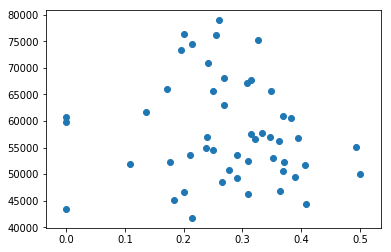

In [114]:
fig, ax = plt.subplots()
plotting = ax.scatter(income_versus_hillary['avarage_positivity'],income_versus_hillary['median_household_income'])

In [113]:
income_versus_hillary['avarage_positivity'].corr(income_versus_hillary['median_household_income'])



# income_versus_trump.info()


-0.10918468107722012